In [4]:
import numpy as np
import cv2
import matplotlib
from matplotlib import pyplot as plt

In [5]:
img=cv2.imread("./dataset/lionel_messi/960.jpg")

In [6]:
img.shape

(620, 960, 3)

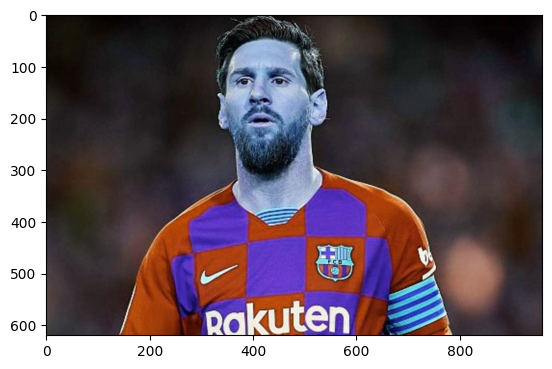

In [7]:
plt.imshow(img)

In [8]:
gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
gray.shape

(620, 960)

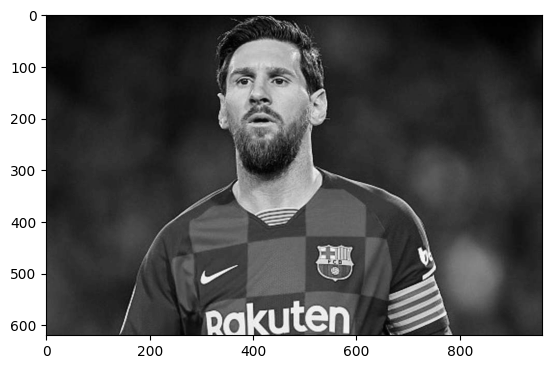

In [9]:
plt.imshow(gray,cmap='gray')

In [10]:
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
faces

array([[315,  43, 203, 203]])

In [11]:
(x,y,w,h)=faces[0]
x,y,w,h

(315, 43, 203, 203)

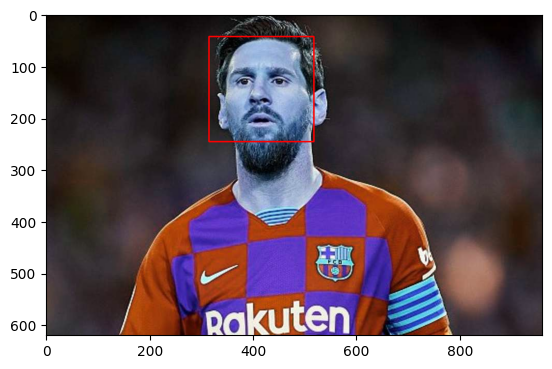

In [12]:
face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
plt.imshow(face_img)

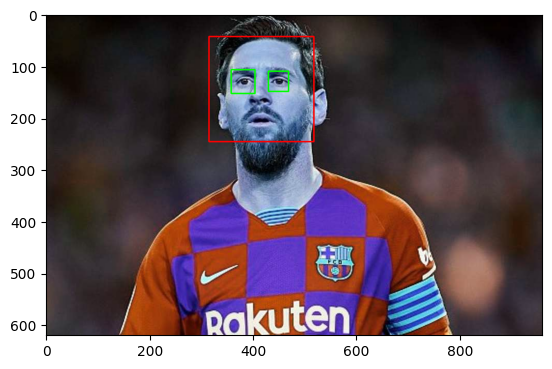

In [13]:
#cv2.destroyAllWindows()
for (x,y,w,h) in faces:
    face_img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = face_img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
        

plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

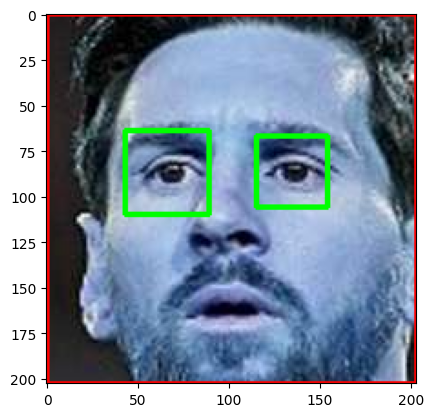

In [14]:
plt.imshow(roi_color,cmap='gray')

In [15]:
def get_cropped_image_if_2_eyes(image_path):
    img=cv2.imread(image_path)
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_cascade.detectMultiScale(gray,1.3,5)
    for (x,y,w,h) in faces:
        roi_gray=gray[y:y+h,x:x+h]
        roi_color=img[y:y+h,x:x+h]
        eyes=eye_cascade.detectMultiScale(roi_gray)
        if len(eyes)>=2:
            return roi_color
       

In [16]:
cropped_img=get_cropped_image_if_2_eyes("./dataset/maria_sharapova/3-681.jpg")

In [17]:
cropped_img

In [18]:
path_to_data="./dataset/"
path_to_cr_data='./dataset/cropped/'

In [19]:
import os
img_dirs=[]
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [20]:
img_dirs

['./dataset/lionel_messi',
 './dataset/maria_sharapova',
 './dataset/roger_federer',
 './dataset/serena_williams',
 './dataset/virat_kohli']

In [21]:
import shutil
if os.path.exists(path_to_cr_data):
    shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [22]:
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./dataset/cropped/lionel_messi
Generating cropped images in folder:  ./dataset/cropped/maria_sharapova
Generating cropped images in folder:  ./dataset/cropped/roger_federer
Generating cropped images in folder:  ./dataset/cropped/serena_williams
Generating cropped images in folder:  ./dataset/cropped/virat_kohli


In [23]:
import numpy as np
import pywt
import cv2    

def w2d(img, mode='haar', level=1):
    imArray = img
    
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )

    imArray =  np.float32(imArray)   
    imArray /= 255;

    coeffs=pywt.wavedec2(imArray, mode, level=level)


    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  


    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

In [24]:
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'lionel_messi': 0,
 'maria_sharapova': 1,
 'roger_federer': 2,
 'serena_williams': 3,
 'virat_kohli': 4}

In [25]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name]) 

In [26]:
len(X[0])

4096

In [27]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(187, 4096)

In [28]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report

In [29]:
x_train,x_test,y_train,y_test=train_test_split(X,y,random_state=0,)

In [30]:
pipe=Pipeline([('scaler',StandardScaler()),('svc',SVC(kernel='rbf',C=5))])

In [31]:
pipe.fit(x_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()), ('svc', SVC(C=5))])

In [32]:
pipe.score(x_test,y_test)

0.8723404255319149

In [33]:
print(classification_report(y_test,pipe.predict(x_test)))

              precision    recall  f1-score   support

           0       0.89      0.80      0.84        10
           1       0.89      1.00      0.94         8
           2       0.80      0.67      0.73         6
           3       0.90      0.82      0.86        11
           4       0.86      1.00      0.92        12

    accuracy                           0.87        47
   macro avg       0.87      0.86      0.86        47
weighted avg       0.87      0.87      0.87        47



In [34]:
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV

In [35]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}











In [36]:
scores = []
best_estimators = {}
import pandas as pd
for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=5, return_train_score=False)
    clf.fit(x_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.735714,"{'svc__C': 10, 'svc__kernel': 'rbf'}"
1,random_forest,0.585714,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.721429,{'logisticregression__C': 1}


In [38]:
best_estimators['svm'].score(x_test,y_test)

0.8723404255319149

In [39]:
best_estimators['logistic_regression'].score(x_test,y_test)

0.851063829787234

In [40]:
best_estimators['random_forest'].score(x_test,y_test)

0.723404255319149

In [41]:
best_clf=best_estimators['svm']

In [42]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_test,best_clf.predict(x_test))
cm

array([[ 8,  0,  1,  1,  0],
       [ 0,  8,  0,  0,  0],
       [ 1,  0,  4,  0,  1],
       [ 0,  1,  0,  9,  1],
       [ 0,  0,  0,  0, 12]], dtype=int64)

Text(95.72222222222221, 0.5, 'truth')

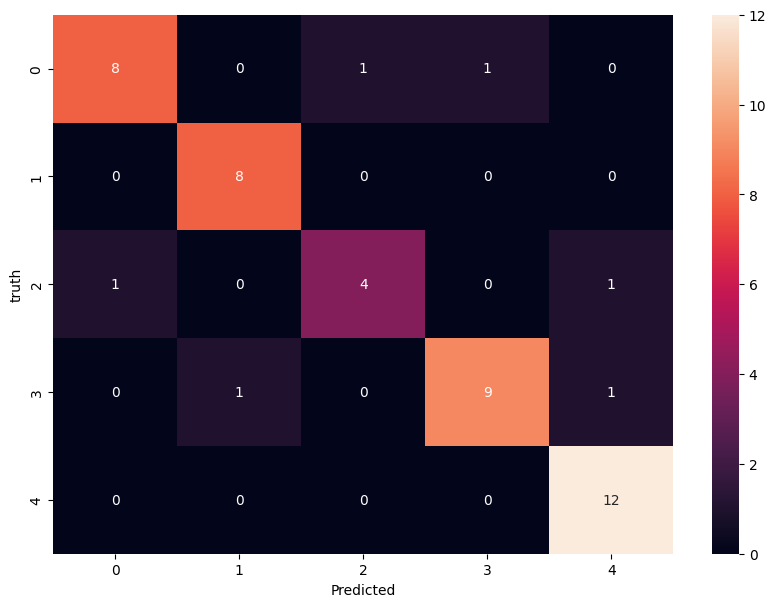

In [43]:
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm,annot=True)
plt.xlabel("Predicted")
plt.ylabel("truth")



In [44]:
import joblib
joblib.dump(best_clf,'saved_model.pkl')



['saved_model.pkl']

In [46]:
import json
with open('class_dictionary.json',"w") as f:
    f.write(json.dumps(class_dict))